# Lesson 8: CADET-Match

As we have seen in the previous lesson, `CADET-Match` is a tool for estimating parameters using CADET.
Amonst others, `CADET-Match` offers functionality for estimating parameters considering: 
* Multiple parameters
* Multiple components
* Per-component parameters
* Multiple experiments
* Multiple scores
* Scores that apply to only a subset of the data
* Fractionation of products


For more information, see also:
- **Source:** https://github.com/modsim/CADET-Match
- **Documentation:** https://cadet.github.io/CADET-Match

**In this lesson,** we will learn:
- Fundamentals of scoring functions, search methods, and parameter transforms.
- Setting up a first simple example with `CADET-Match`

## Example: Automatic determination of porosity and axial dispersion of a Column

Again we look at the previous example where we manually tried to determine the porosity and axial dispersion of a column.

### Load CADETSettings

This imports all the standard libraries and provides some helper functions.

In [1]:
%run ../utils.ipynb

## Create CADET-Match configuration

For configuring `CADET-Match`, we simply create an instance of a `Dict` from the `addict` module. 
We also again need to provide the path to the `CADET-cli`, and set the base directory for the current parameter estimation procedure (all paths are read relative to this directory).

In [2]:
from addict import Dict

base_dir = Path('./').absolute()

match_config = Dict()
match_config.CADETPath = Cadet.cadet_path
match_config.baseDir = base_dir.as_posix()
match_config.resultsDir = 'results'

### Create reference model

First, we need to model our system.
For this purpose, we configure a `CADET` model as explained in the previous lessons.
In this exercise, we will reuse the previous example which included an `INLET`, a `LUMPED_RATE_MODEL_WITH_PORES`, and an `OUTLET`.
We can load a preconfigured model from the utils by calling `create_dextran_model`.

<div class="alert alert-warning">

**Warning:** 

In order for `CADET-Match` to work, it is important to set `SPLIT_COMPONENTS_DATA` in the [`/input/return`](https://cadet.github.io/interface/return_data.html) group to `True`.
With this, a separate dataset for each component is created (`XXX_COMP_000`, `XXX_COMP_001`,...).

</div>

It is important to remember the location of the `.h5` file because we later need to add it to the experiments.

In [3]:
dextran_model = create_dextran_model()
run_simulation(dextran_model, 'dextran_reference.h5')

Simulation completed successfully


### Parameters

From our reference model, we can now select any number parameters and add them to `CADET-Match`.
First, we need to specify the path to the parameter in the model.
Moreover, for every parameter, we can specify:

- min: `float`\
  minimum value the parameter should take.
- max: `float`\
  maximum value the parameter should take.
- component: `int`\
  index of the component. `-1` means the parameter is independent of components.
- bound: `int`\
  bound state. `-1` means the paramter is indepdent of bound states.
- transform: `str`\
  one of `{'null', 'auto', 'auto_keq', 'auto_inverse', 'norm_volume_area', 'norm_volume_length', 'set_value'}`.
    
Again, we create another `Dict` for every parameter and specify the required data.
For now, we will ignore the transform but we will look at them later in detail.
Then, we add them to the parameters list of the `match` object.

In [4]:
parameter1 = Dict()
parameter1.location = '/input/model/unit_001/COL_DISPERSION'
parameter1.min = 1e-10
parameter1.max = 1e-6
parameter1.component = -1
parameter1.bound = -1
parameter1.transform = 'null'

parameter2 = Dict()
parameter2.location = '/input/model/unit_001/COL_POROSITY'
parameter2.min = 0.2
parameter2.max = 0.7
parameter2.component = -1
parameter2.bound = -1
parameter2.transform = 'null'

match_config.parameters = [parameter1, parameter2]

### Adding experimental data

Next, we need to specify the experimental data with which the simulation will be compared to (see also in the [documentation](https://cadet.github.io/CADET-Match/master/configuration/experiments.html)).
Currently, `CADET-Match` only handles `.csv` files for experimental data.
For this demonstration, the data can be found unter `/resources/dextran_experiment.csv`.

We also need to provide the path of the `.h5` file that has the base simulation in it.
Furthermore, we need to specify the path of the data in the `Cadet` model that needs to match the experimental data.

We create another `Dict` for every experiment and specify the required data.
Then, we add the experiment to the `match` experiments list.

In [5]:
experiment1 = Dict()
experiment1.name = 'dextran'
experiment1.csv = '../resources/dextran_experiment.csv'
experiment1.HDF5 = 'dextran_reference.h5'
experiment1.output_path = '/output/solution/unit_002/SOLUTION_OUTLET_COMP_000'

match_config.experiments = [experiment1,]

### Featues and scores

Scores are how the search algorithm measures if a solution is better or worse than what it had before. 
Without a good score system an optimizer can't work. 
There are many scores available and here we will discuss the most commonly used ones. 
A complete overview can be found [here](https://cadet.github.io/CADET-Match/master/configuration/scores.html).

Most of these scores are based on physical understanding of the problem and it is pretty easy to add new scores.
If there is a feature you can identify in your problem that ties to one of the variables being estimated then go ahead and make a score for it.
Maybe for your isotherm the width of the peak or some other feature reveals important information.

1. **Shape**\
  This is the default score used when fitting an isotherm. 
  It looks at the shape, position, and height of the peak. 
  It has a small initial penalty for the peak being out of position in time and increases as the peak gets further away. 
  This is to deal with the problem of pump delays and other experimental errors. 
  The best fit may not be and often is not the peak that is in exactly the right location but it is the one with the right shape. 
  The shape is determined by the physics which is why it is so heavily emphasied in the score system.

1. **ShapeDecay**\
  This is the default score to use when fitting transport parameters. 
  Transport experiments are more difficult because you MUST make sure that as few errors as possible happened in the physical experiment. 
  On most AKTA type systems if there is an alarm the timer for data collection is also paused until the alarm is cleared and the system resumes. 
  his results in data that has no gap in the time. 
  However, the chemicals are still reacting and moving even if the pumps are off and data collection stops. 
  Any such error that occurs will result in the diffusion being wrong and the longer the error persists before being fixed the more wrong the estimate for diffusion will be. 
  Things like pump delays or other pauses in the system can cause problems with estimating volume or porosity. 
  Any errors that occur in transport experiments will be carried through to isotherm parameters which harms scaleup later.
  
1. **ShapeFront**\
  This score looks at only the front of the peak. 
  It is designed to use with a breakthrough that just levels off and does not go back down.

1. **ShapeBack**\
  This score looks at only the back of the peak. It is designed for situations that start at a high concentration and drops over time.

1. **DextranShape**\
  Dextran is a nice tracer overall but it has non ideal behavior in most systems. 
  You normally see this in strange tailing behavior. 
  What this means is that only the front side of the peak can be used. 
  This score specifically looks only at the front side of the peak.
  
1. **DextranSSE**\
  This works like DextranShape and cuts out just the front part of the peak but uses SSE for the score. **This score can not be combined with any of the other scores since it does not range from 0 to 1.**

1. **fractionationSlide**\
  If you have a fractionation proble use this score. Internally it is a little complex. After each simulation for each species it numerically slides the chromatogram back and forward in time and refactionates at each time to find which location best matches the experimental data to find the time difference between the synthetic and experimental peak along with a shape comparison at that time.

1. **SSE**\
  This is the Sum of Squared Errors. **This score can not be combined with any of the other scores since it does not range from 0 to 1.**

1. **AbsoluteHeight** and **AbsoluteTime**\
  These scores are needed by the MCMC system. They are absolute measurements of height and time since the beginning of the simulation. They are used to capture the impact of errors that have an assymetric impact on the peaks.

To add a feature in CADET-Match, create a `Dict` and add it to the list of features of the experiment.

In [6]:
feature1 = Dict()
feature1.name = "Pulse"
feature1.type = 'SSE'

experiment1.features = [feature1,]

### Search Method

There are 5 main search methods and only 3 of them are normally used. For more details, please see the [documentation](https://cadet.github.io/CADET-Match/master/configuration/search.html).

1. **NSGA3**\
  This is the default evolutionary algorithm and the best choice to use when you don't know anything about your search space.

1. **Multistart**\
  This is a multistart gradient descent algorithm. If your problem can be solved with gradient descent then this can be a very good choice. It creates an initial population the same way that NSGA3 does so that you don't have to worry about starting point. 

1. **GraphSpace**\
  This is not for optimization and instead it is just for sampling the space. If you have a new problem and you have no idea what the range of any of the parameters are you can use this with a very large population and it will just evaluate the entire starting population and then terminate. This allows you to figure out what are plausiable ranges for your variables before using one of the search algorithms. When dealing with many variables it is still possible to miss regions of viable solutions inside large non-viable regions but in practice this has rarely been a problem.

1. **MCMC**\
  This performans the error modeling and sampling. It is not an optimization algorithm and while it will probably find the optimum value while it runs it is very slow to do so and won't stop even if it finds the optimal value. This should also not be used directly. Normally NSGA3 is used and an option is set to continue with MCMC after NSGA3 has completed. This allows MCMC to be seeded with the best values from NSGA3 which dramatically improves convergence. If you have many variables and you run this directly it may never converge since it may never find high probability regions, much less sample from them effectively. 
 
1. **Gradient**\
  This is a single start gradient descent algorithm. In order to work you need to give a good enough starting point. Generally it is advisable to use Multistart instead.

**In this case,** we will use the 'NSGA3' search method.

It also enables us to set some optimizer parameters:

- population: `int`\
  Number of individuals that are evaluated per generation (good default: 100)
- stallGenerations: `int`\
  Number of generations without progress before the search is terminated (good default: 10-50)
- finalGradRefinement: `Bool`\
  If `True`, run gradient descent on the final values to refine them further
- gradVector: `Bool`\
  Setting for gradient refinement. Use `True` to have SSE for refinement and `False` to use the score for gradient refinement

In [7]:
match_config.searchMethod = 'NSGA3'
match_config.population = 12
match_config.stallGenerations = 10
match_config.finalGradRefinement = True
match_config.gradVector = True

## Saving the config and running the optimization

We save the match config as a `.json` file by calling the `json.dump()` method.

Most of the time, `CADET-Match` would be started from a command line on a powerful server (for more information, see [here](https://cadet.github.io/CADET-Match/master/cli/index.html)).
However, to start the parameter estimation in a juypter notebook, we can import the `Match` class from the `CADETMatch.jupyter` submodule.
All of the same results are generated as when the matching software is run directly on the command line and the full results can still be viewed.
We create an instance by passing the path of the config that we just saved to the `__init__` function of the `Match` class and start the optimization by calling the `start_sim` method.

In [8]:
from CADETMatch.jupyter import Match

match_config_file = base_dir / 'dextran.json'

with open(match_config_file.as_posix(), 'w') as json_file:
    json.dump(match_config.to_dict(), json_file, indent='\t')

match = Match(match_config_file)
match.start_sim()

<frozen importlib._bootstrap>:228: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 88 from PyObject
/home/jo/software/miniconda3/envs/chromapy/lib/python3.9/subprocess.py:941: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdout = io.open(c2pread, 'rb', bufsize)


2021-10-26 11:57:13,928 match.py print_version 121 CADETMatch starting up version: 0.8.13

2021-10-26 11:57:13,955 match.py print_version 150 attrs version: 21.2.0 tested with 21.2.0

2021-10-26 11:57:13,958 match.py print_version 150 joblib version: 1.1.0 tested with 1.0.1

2021-10-26 11:57:13,960 match.py print_version 150 addict version: 2.4.0 tested with 2.4.0

2021-10-26 11:57:13,962 match.py print_version 150 corner version: 2.2.1 tested with 2.2.1

2021-10-26 11:57:13,965 match.py print_version 150 emcee version: 3.1.1 tested with 3.0.2

2021-10-26 11:57:13,967 match.py print_version 150 SALib version: 1.4.5 tested with 1.3.11

2021-10-26 11:57:13,969 match.py print_version 150 psutil version: 5.8.0 tested with 5.8.0

2021-10-26 11:57:13,970 match.py print_version 150 numpy version: 1.20.3 tested with 1.21.1

2021-10-26 11:57:13,972 match.py print_version 150 openpyxl version: 3.0.9 tested with 3.0.7

2021-10-26 11:57:13,974 match.py print_version 150 scipy version: 1.7.1 tested

## Analyze results

The system creates a number of sub directories and depending on what settings are in the JSON file some will be empty.

The import ones are

1. **log**\
  This contains all the log files from the system. If something goes wrong the information is usually here to find the problem and fix it. This is especialy useful for us to help with a problem.
2. **meta**\
  This contains all the results on the pareto front of meta scores. Your best results will be in this folder. There are simulations, images and results in csv and xlsx format to view.
3. **progress**\
  This folder watches the general progress of the algorithm. In this folder you can see if your variables are identifiable or the progress the search method is making.
4. **space**\
  This folder has plots for what the search space looks like. This is especially useful for debugging. Based on graphs in this folder you can expand or contract the search range for your variables which can improve the fits.
  
There are also some important items in this folder
1. `error.csv`\
  If any simulation fails it will be recorded here
2. `json file`\
  This is the JSON used to create this simulation. It is a copy of the JSON file you started the matching process with
3. `progress.csv`\
  This file contains some information on algorithm progress. Of special interest are the last two columns that show the last generation where a new item was added to the pareto front of meta scores and how many generations in a row that progress has been made. If enough generations pass without progress the search will terminate.
4. `result.h5`\
  This is an HDF5 file that contains enormous information about the system. It has the entire population, the scores for all items, and other information. With HDFview you can easily view these files and with python you can read any information you want from these files.
5. `csv file`\
  There is one last csv file that is named based on the JSON configuration file and it shows every simulation the system has run along with the scores for that simulation.

## Create corner plots
These are frequency plots of each variable in your system along with their correlations. What you are looking for is a single peak and this indicates that your variable is identifiable. The peak may be more or less narrow depending on the ranges you gave to the optimizer. If you use an early stopping criteria these plots probably won't be accurate. What is happening is that as the system converges it searches around the best found values to try and find better ones. This means that there are many similar values and so the frequency goes up which shows up as a peak.

Corner plot in search space


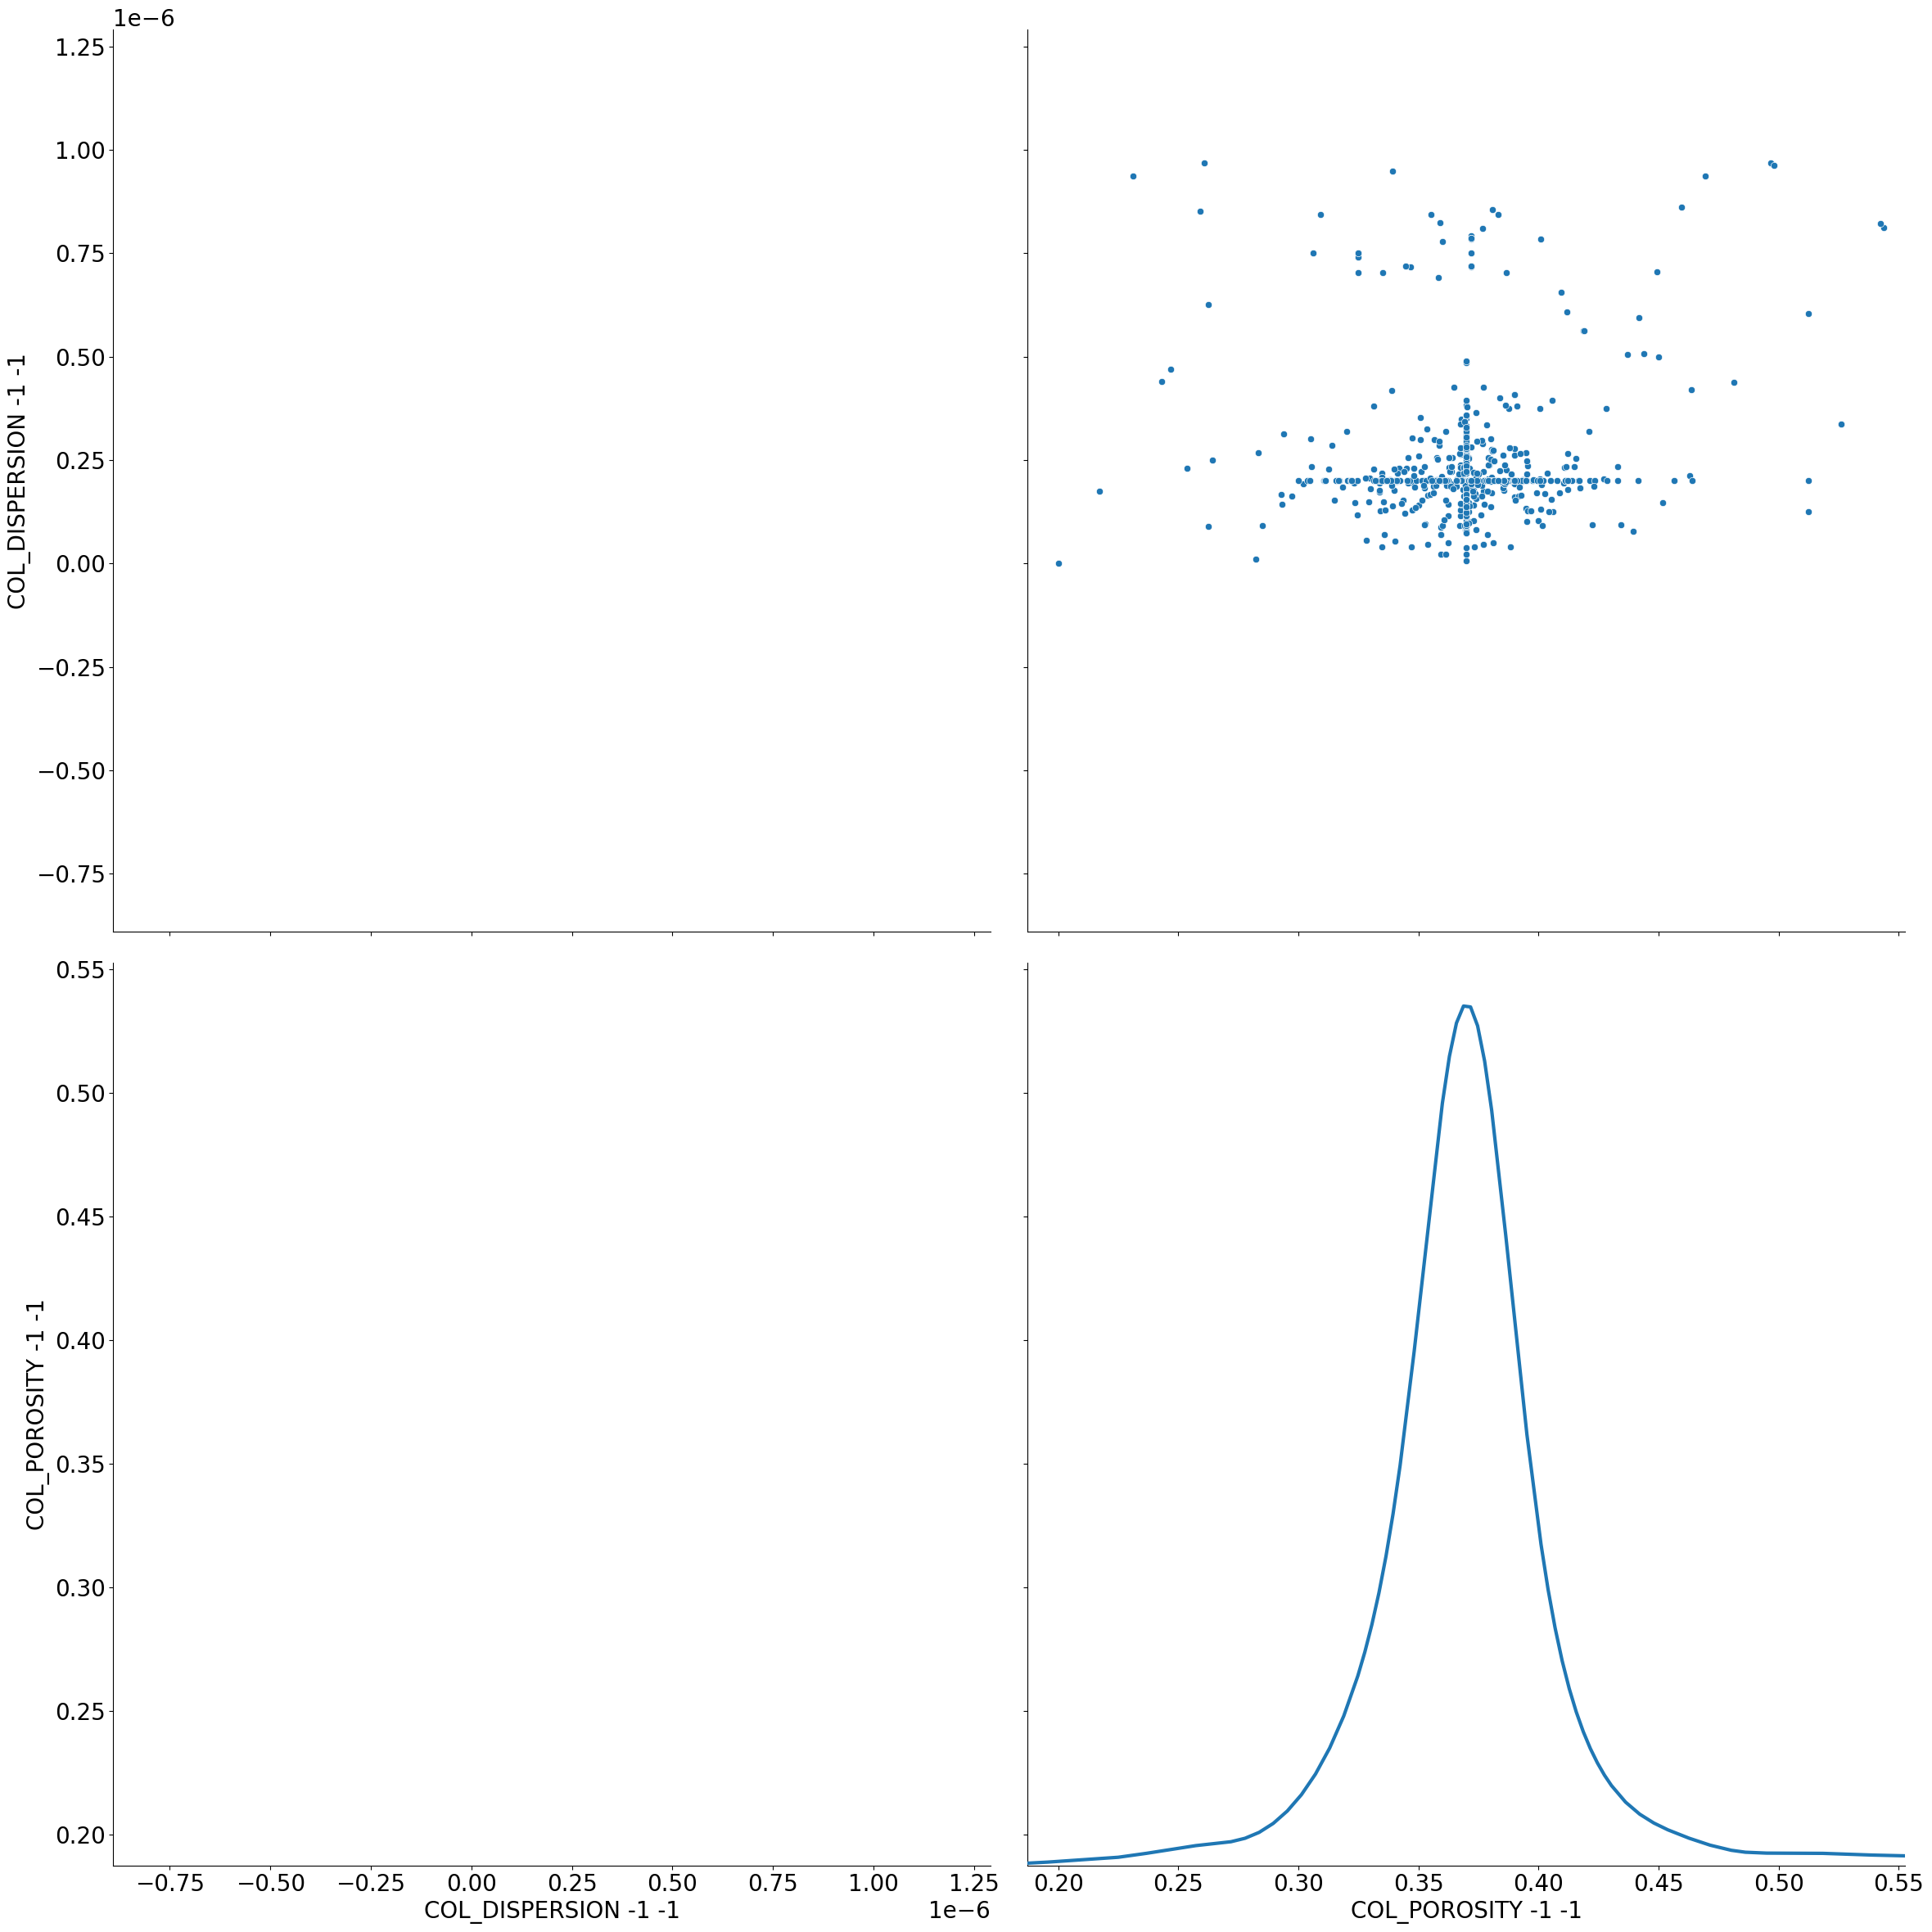

Corner plot in original space


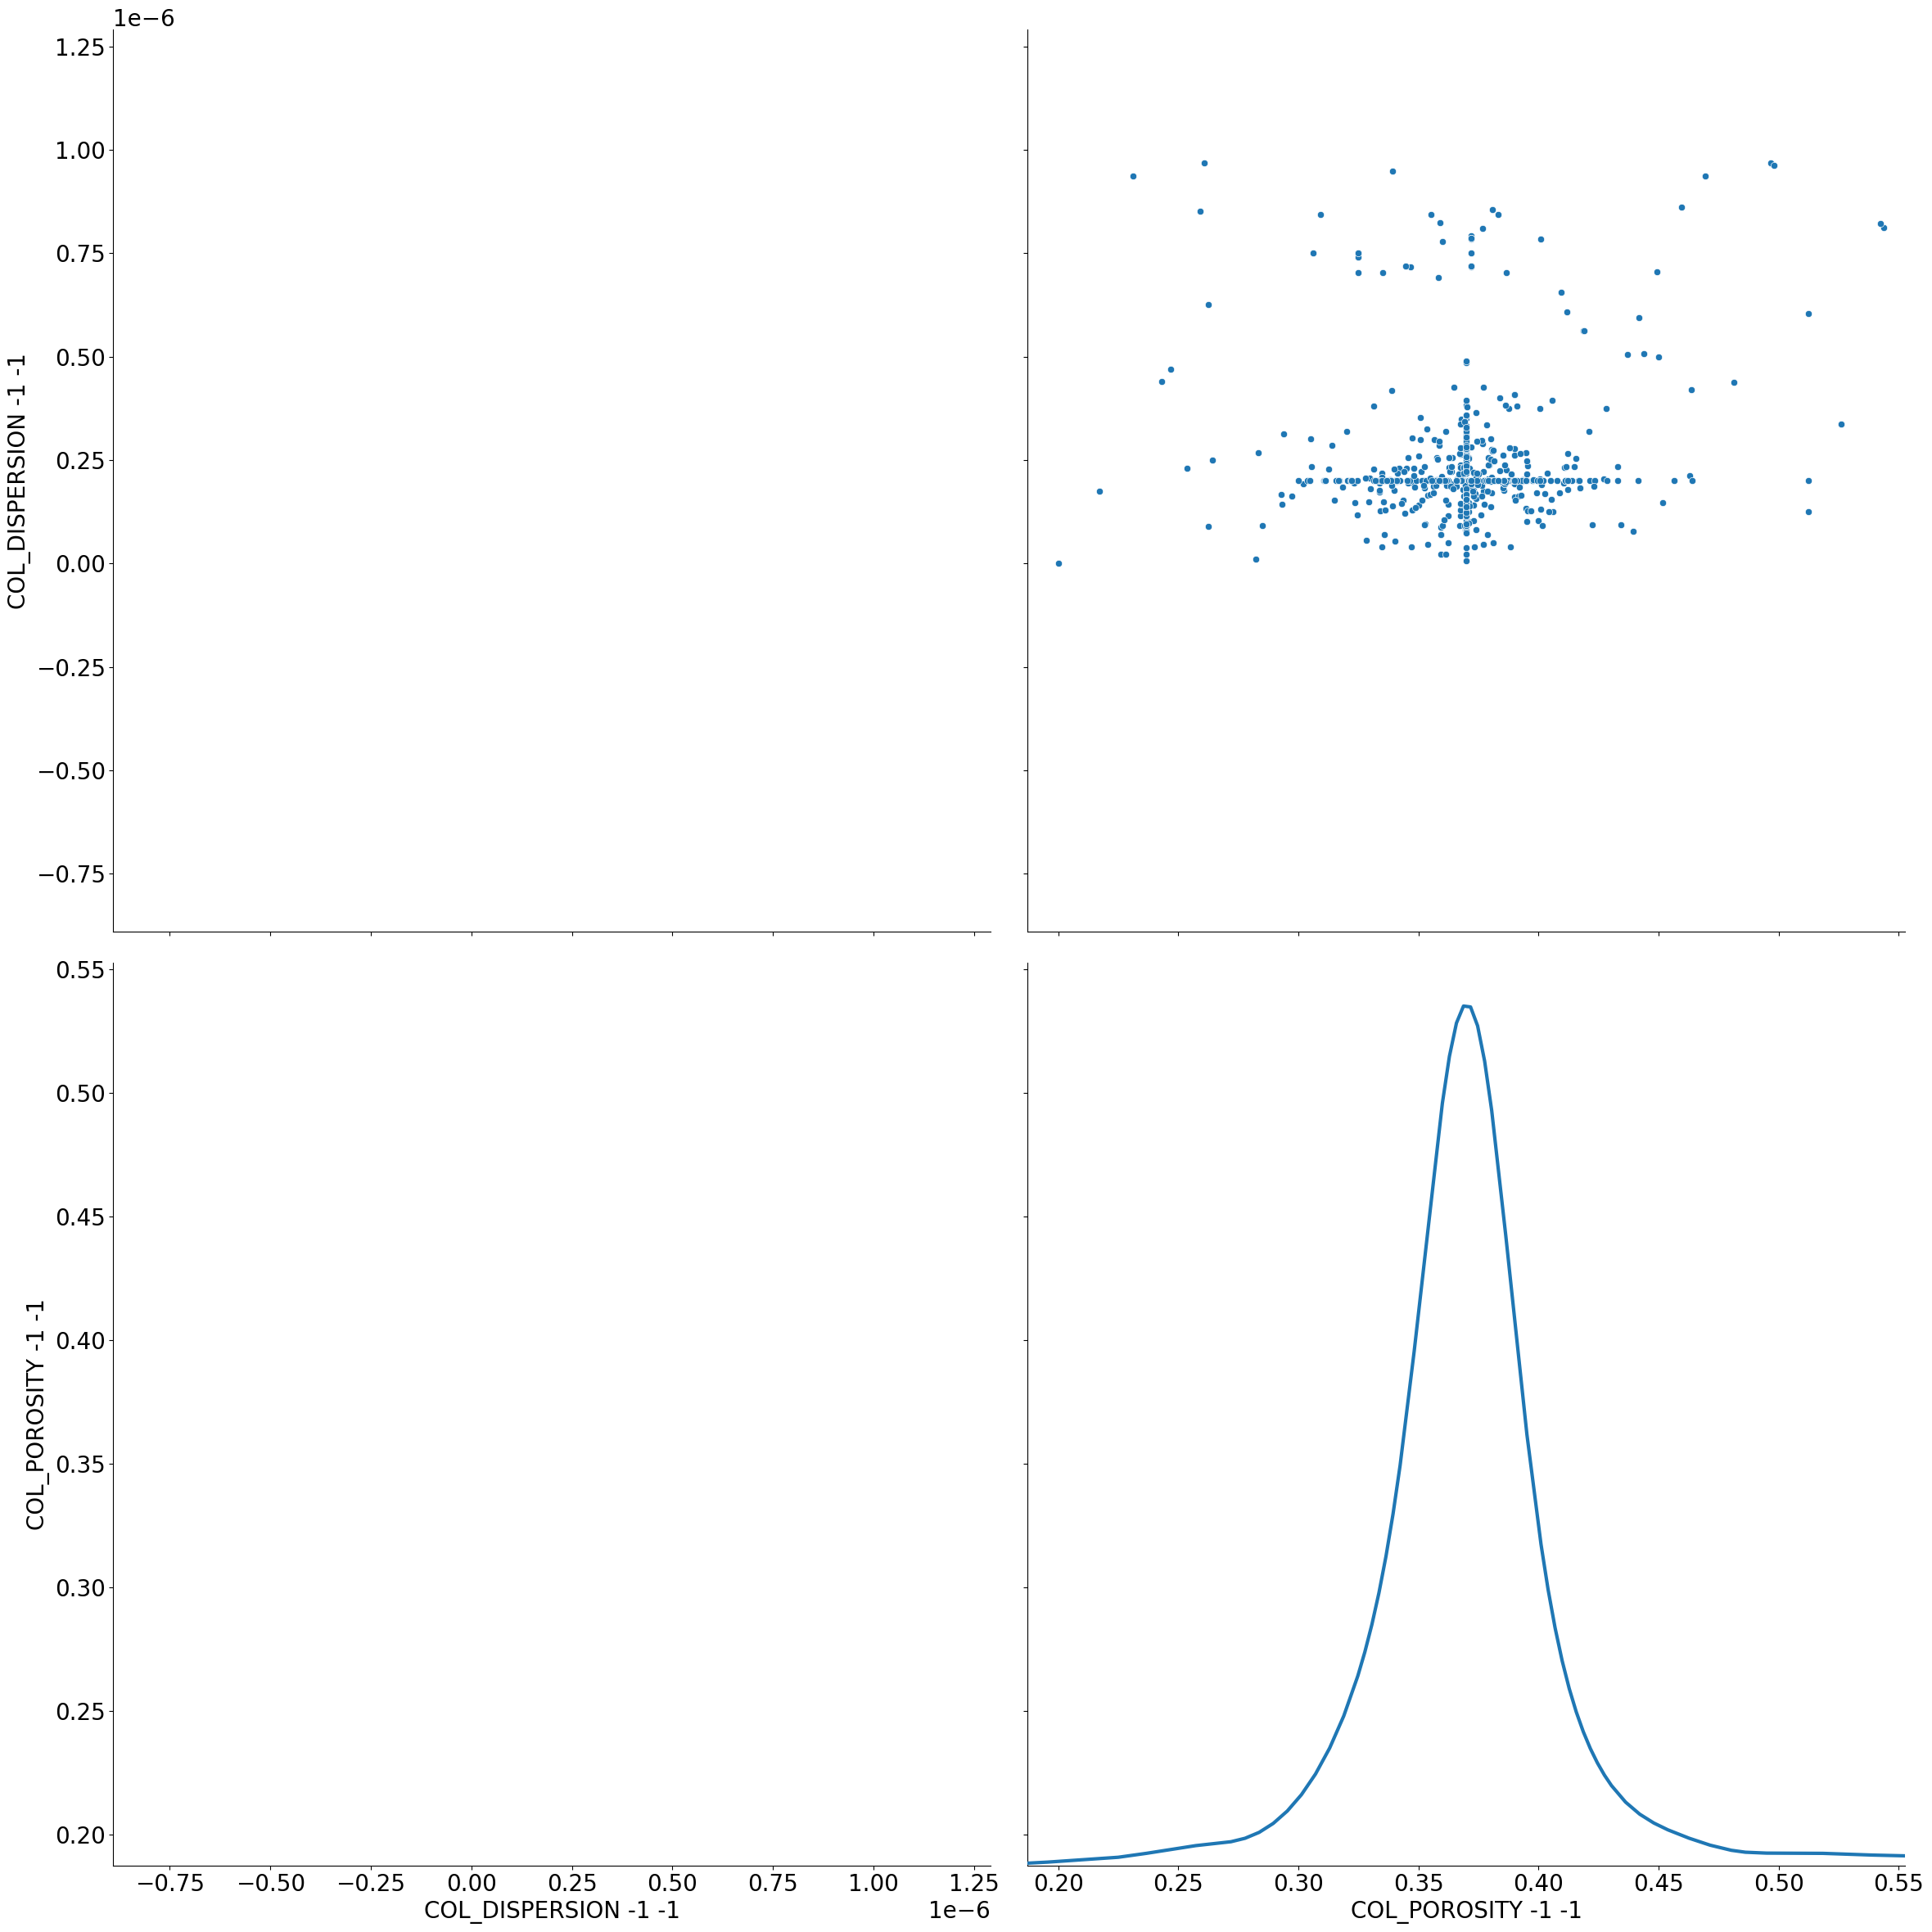

In [9]:
match.plot_corner()

## Best plots

This draws a selection of items from the meta folder. 
It will look in the folder and find the highest Product Root Score, Min Score and Mean Score and the lowest SSE and plot all of those entries. 
There may still be other items in those folders which are compromises between these scores. 
The plot will show the ID of the best found item, by what measurements it is the best and what its paramters are.

Best item 1181ece0db477f1fa6ff75319e35a43d for meta score(s) Product Root Score , Min Score , Mean Score , SSE


,Time,Name,Method,Condition Number,COL_DISPERSION Comp:-1 Bound:-1,COL_POROSITY Comp:-1 Bound:-1,dextran_Pulse_SSE,Product Root Score,Min Score,Mean Score,SSE,RMSE
0,Wed Dec 16 11:00:08 2020,1181ece0db477f1fa6ff75319e35a43d,GRAD,28311.65586,2.000000e-07,0.37,2.288412e-26,2.288412e-26,2.288412e-26,2.288412e-26,2.288412e-26,7.077922e-15


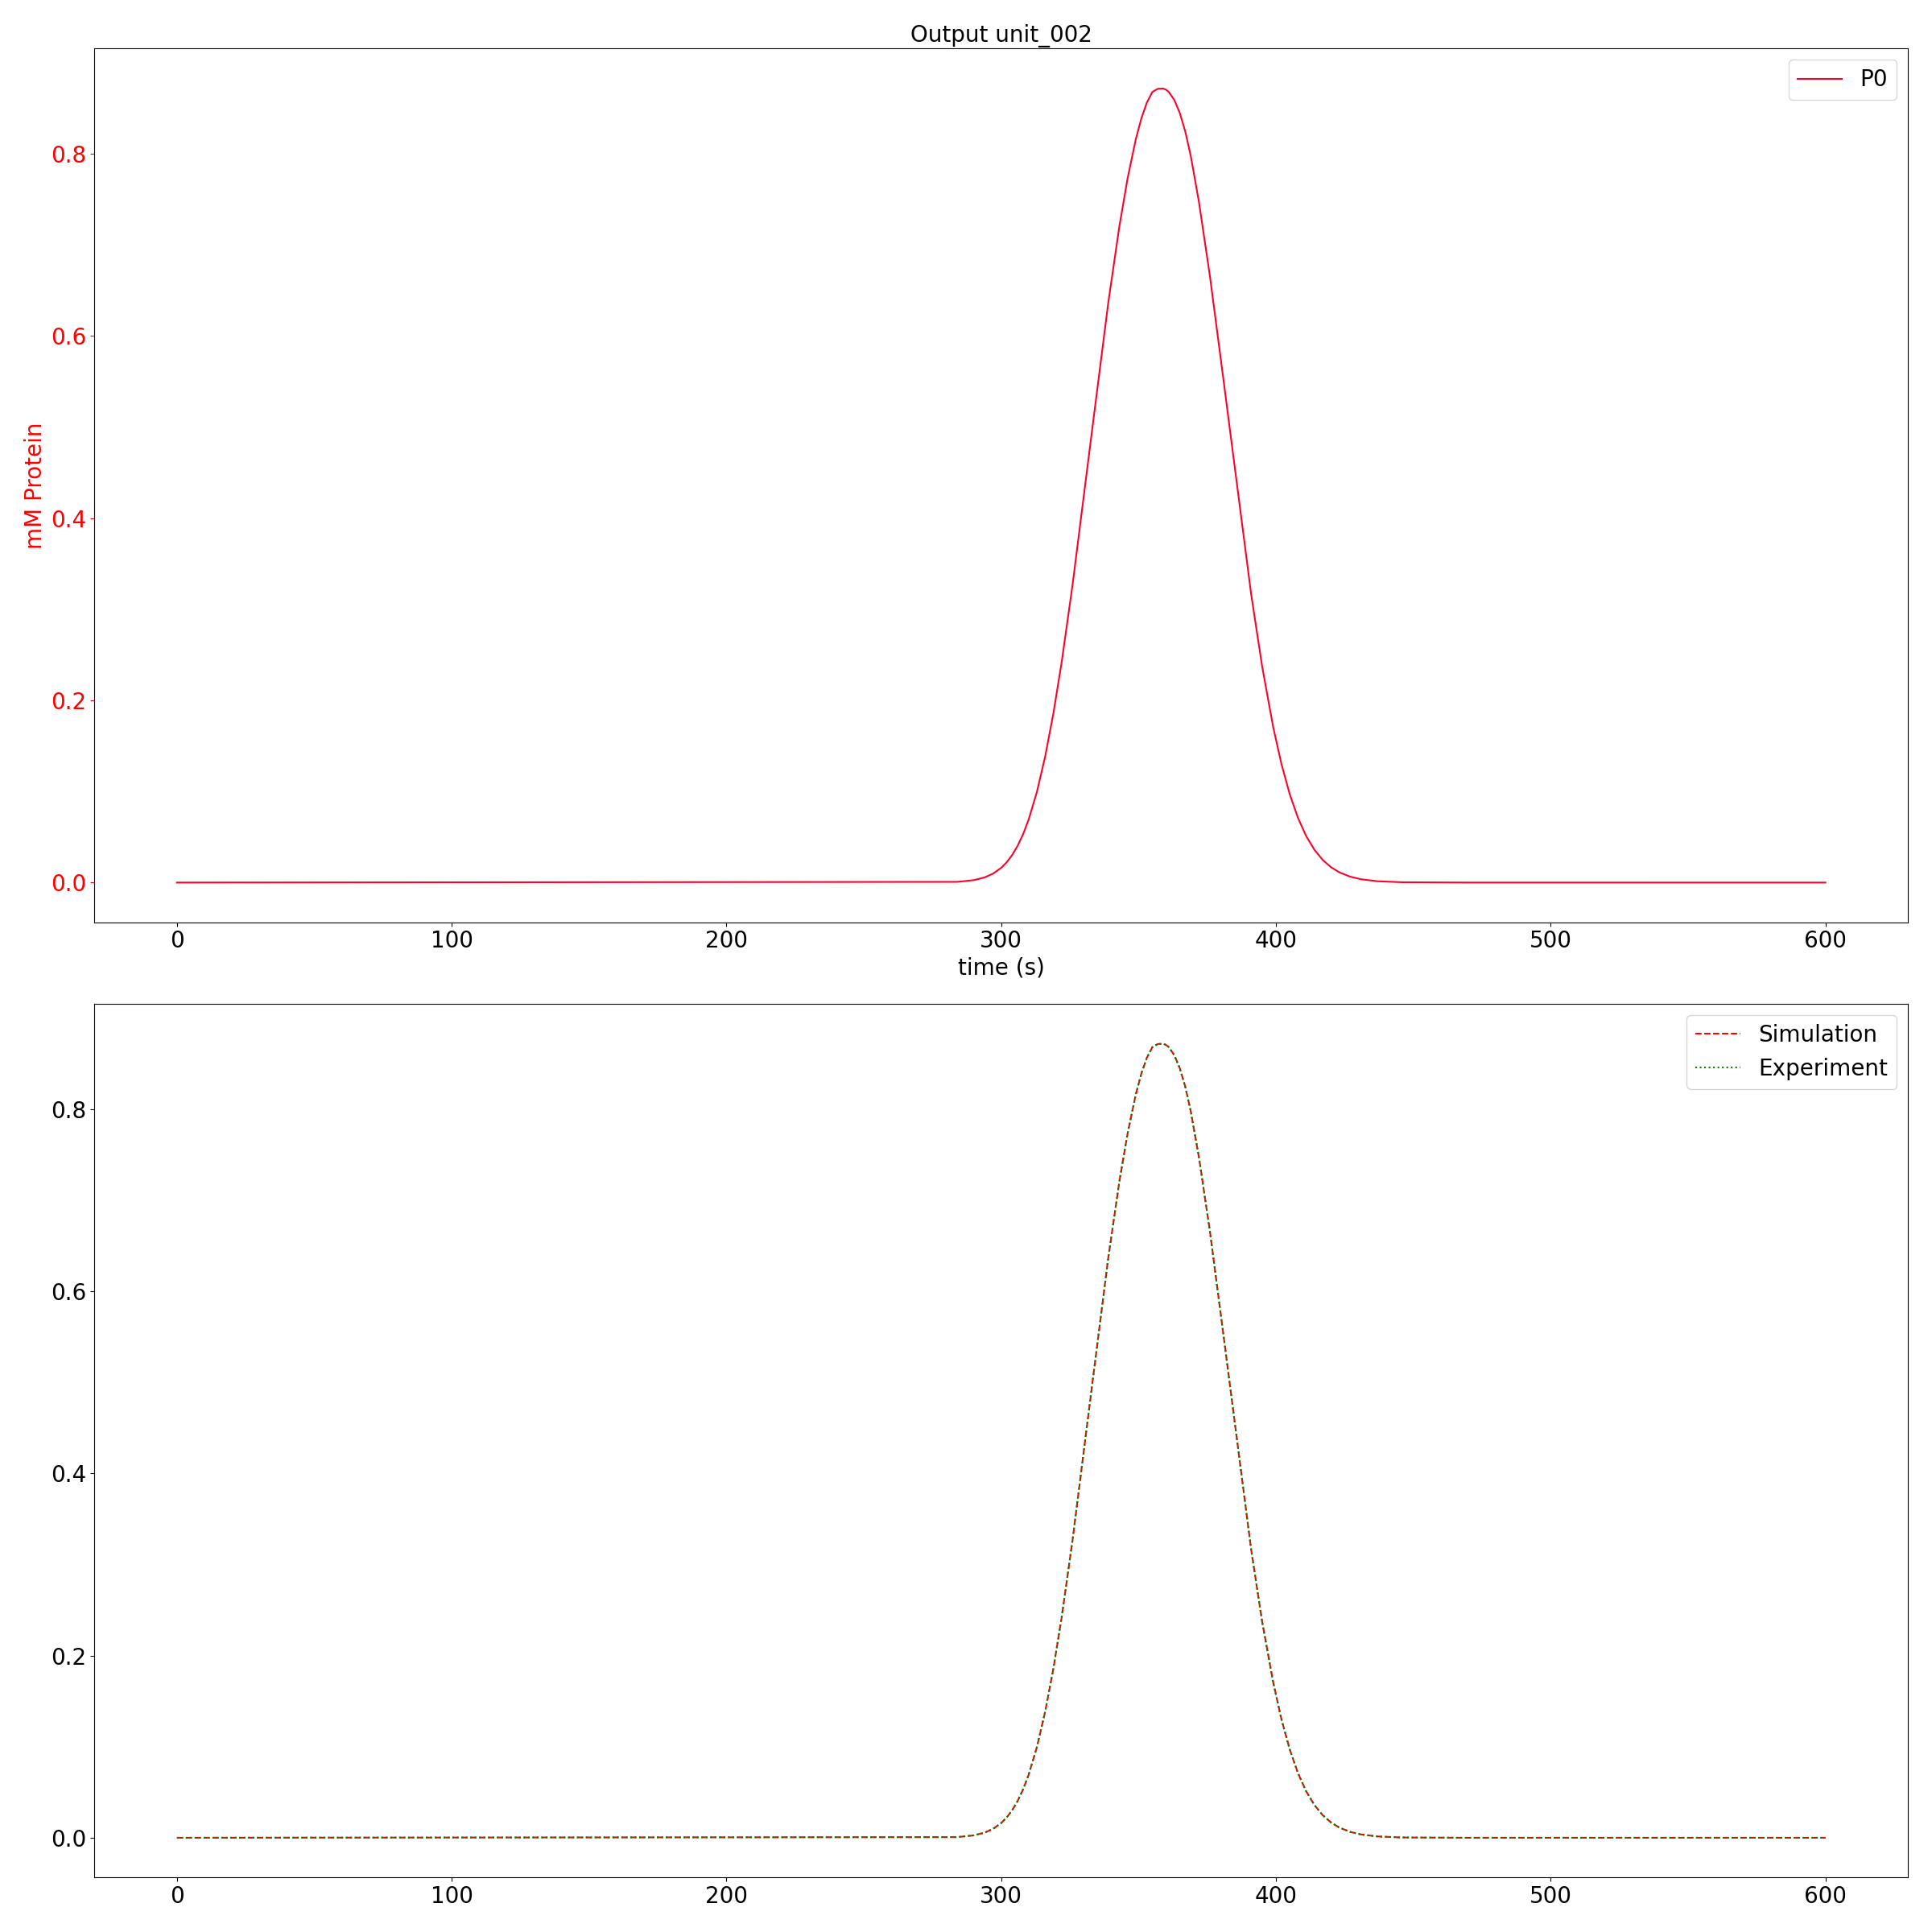

In [10]:
match.plot_best()

## Variable transforms

Search algorithms don't work well when the parameters have very different ranges.
For example if one parmeter varies from $1 \cdot 10^{-5}$ to $1 \cdot 10^{-10}$ and the other varies from $1$ to $10$.
Another problem is when parameters are tightly coupled together but presented to the optimizer as indepdent variables. 
For example, the adsorption and desorption rates kA and kD are coupled together but given as two different variables while they do not freely vary from each other. 
To solve this problem variable transforms are available. 
A complete overview of all transforms can be found [here](https://cadet.github.io/CADET-Match/master/configuration/transform.html).


1. **auto**\
  This is a transform that normalizes a variable from 0 to 1. 
  If max/min < 1e-3 a lot transform is used otherwise a linear transform is used.

1. **auto_keq**\
  This transform turns ka, kd in ka and keq=ka/kd and then takes a normalizes from 0 to 1. 
  If maxKA/minKA > 1e3 a log transform is used otherwise a linear transform is used. 
  If maxKEQ/minKEQ > 1e3 a log transform is used otherwise a linear transform is used.
  
1. **auto_inverse**\
  This transform normalizes from 0 to 1 and uses a log transform for max/min > 1e3 otherwise a linear transform.
  The variable used is 1/x and this is designed for estimating film diffusion and pore diffusion with a non-binding pulse. 
  Applying this transform to both film diffusion and pore diffusion decouples the variables to some extent and improved parameter estimation and MCMC.
  
1. **norm_volume_area**\
  This transform and the following one where created to solve the same common problem. 
  When fitting bypass data and you model the tubing you are fitting the length, crosssectional area and dispersion of the tubing. 
  Dispersion though is tied to the length such that a shorter length can just be compensated for with a higher diffusion. 
  Basically we have fewer degrees of freedom that we are fitting with and since this is not a fluid dynamics model it is not physically accurate. 
  This transformation couples the length and area together through the volume since volume is an identfiable quantity (since water is incompressible). 
  We don't actually care much about the parameters for the tubing, it is just there to fill in for the real tubing so that fewer errors are carried into the column. 
  Use this version if it is easier to measure the diameter of the tubing and use the other transform if measuring the length is easier. 
  It just depends on your experimental setup.

1. **norm_volume_length**\
  Use this transform if measuring the length accurately is easier than measuring the diameter of the tubing. 
  If you are lumping together all the tubing in front of the column or after the column together and you have multiple diameters it doesn't matter which of these transforms you choose.

1. **set_value**\
  This is a different kind of transform. 
  What it allows you to do is copy a value from place to another. 
  This is important if you are estimating axial dispersion for identical tubing in front of and behind the column. 
  You want the same axial dispersion for both pieces of tubing but you only want to estimate one variable. 
  With this you can estimate axial dispersion for the first piece of tubing and then copy the value over to the other piece of tubing. 
  This is also required if you want to estimate SMA_LAMDA. Whenever SMA_LAMBDA change the initial bound salt concentration also much change or electronuetrality would be violated.

In this example we will look again at the previous example. 
This time, we will tell `CADET-Match` to normalize the variable using the `auto` method.

In [11]:
parameter1 = Dict()
parameter1.location = "/input/model/unit_001/COL_DISPERSION"
parameter1.component = -1
parameter1.bound = -1
parameter1.min = 1e-10
parameter1.max = 1e-6
parameter1.transform = 'auto'

parameter2 = Dict()
parameter2.location = "/input/model/unit_001/COL_POROSITY"
parameter2.component = -1
parameter2.bound = -1
parameter2.min = 0.2
parameter2.max = 0.5
parameter2.transform = 'auto'

In [12]:
match = Dict(match_config)
match.CADETPath = cadet_path.as_posix()
match.baseDir = base_dir.as_posix()
match.resultsDir = 'fit_grad'
match.searchMethod = 'NSGA3'

match.parameters = [parameter1, parameter2]

In [13]:
match_config_file = base_dir / 'dextran_auto.json'

with open(match_config_file.as_posix(), 'w') as json_file:
    json.dump(match.to_dict(), json_file, indent='\t')

match = Match(match_config_file)
match.start_sim()

/home/jo/software/miniconda3/envs/chromapy/lib/python3.9/subprocess.py:941: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdout = io.open(c2pread, 'rb', bufsize)


2021-10-26 11:57:17,978 match.py print_version 121 CADETMatch starting up version: 0.8.13

2021-10-26 11:57:17,997 match.py print_version 150 attrs version: 21.2.0 tested with 21.2.0

2021-10-26 11:57:17,998 match.py print_version 150 joblib version: 1.1.0 tested with 1.0.1

2021-10-26 11:57:17,998 match.py print_version 150 addict version: 2.4.0 tested with 2.4.0

2021-10-26 11:57:17,999 match.py print_version 150 corner version: 2.2.1 tested with 2.2.1

2021-10-26 11:57:18,000 match.py print_version 150 emcee version: 3.1.1 tested with 3.0.2

2021-10-26 11:57:18,001 match.py print_version 150 SALib version: 1.4.5 tested with 1.3.11

2021-10-26 11:57:18,002 match.py print_version 150 psutil version: 5.8.0 tested with 5.8.0

2021-10-26 11:57:18,003 match.py print_version 150 numpy version: 1.20.3 tested with 1.21.1

2021-10-26 11:57:18,003 match.py print_version 150 openpyxl version: 3.0.9 tested with 3.0.7

2021-10-26 11:57:18,004 match.py print_version 150 scipy version: 1.7.1 tested

Corner plot in search space


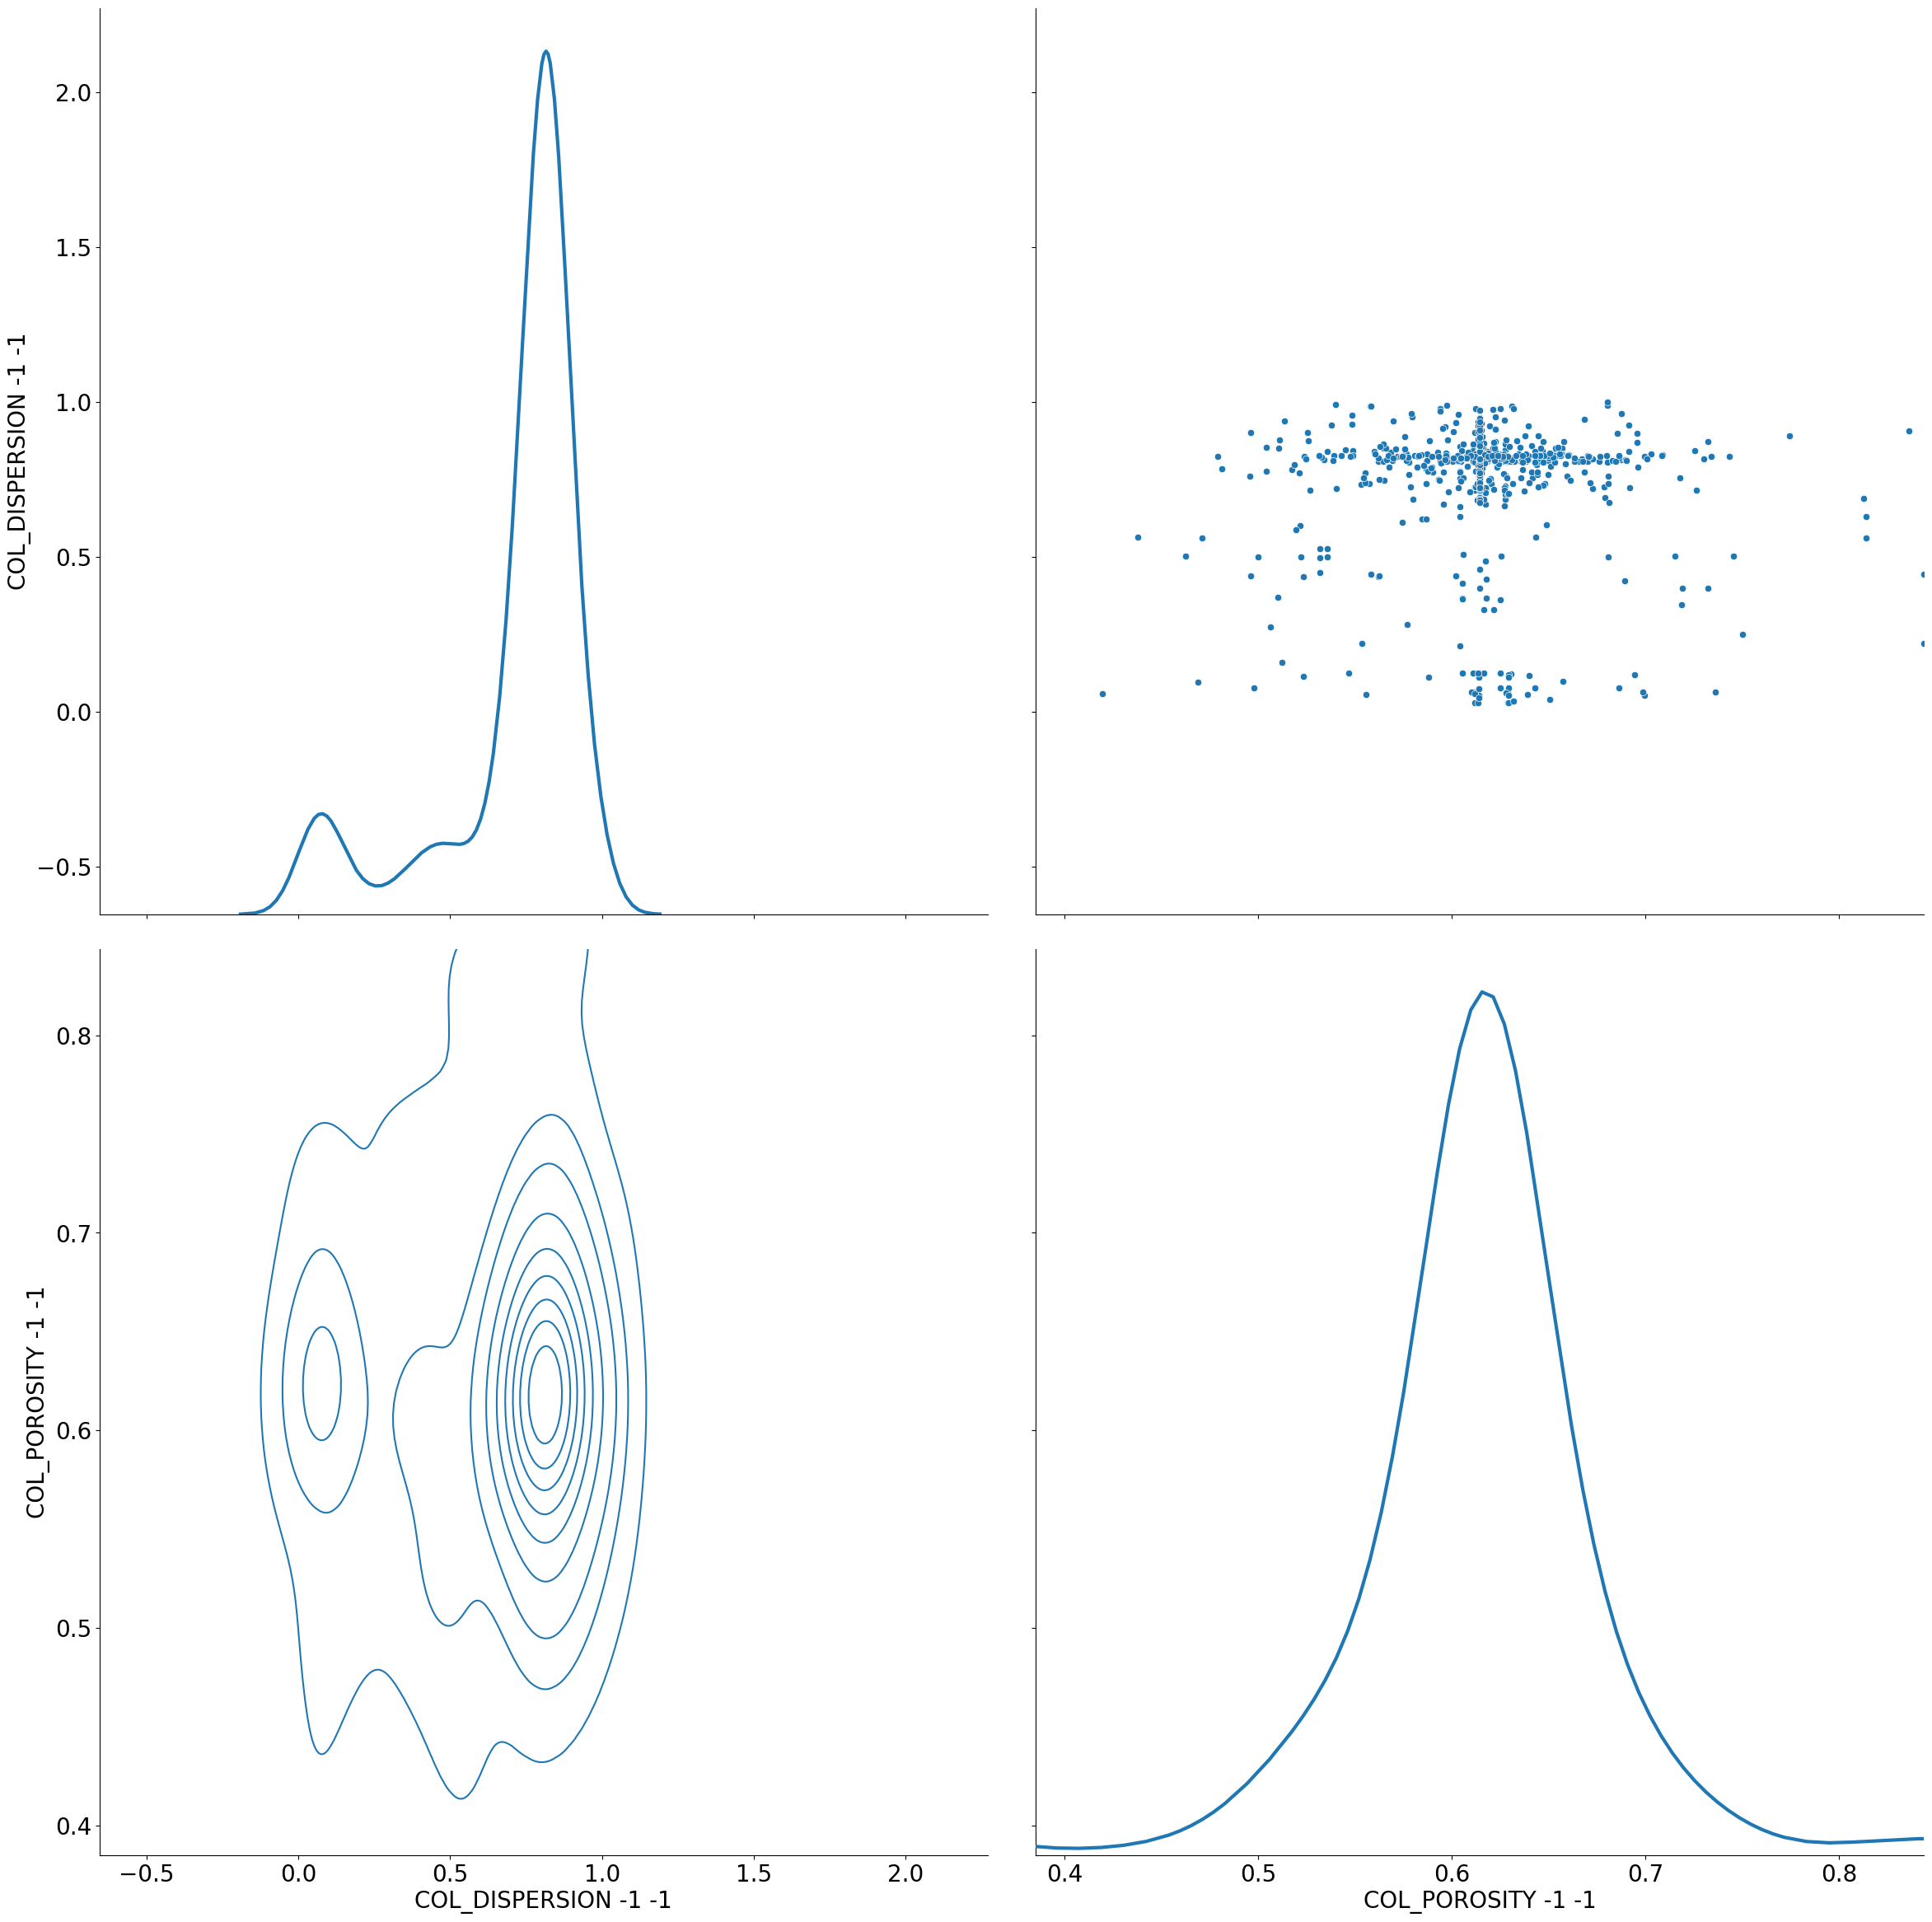

Corner plot in original space


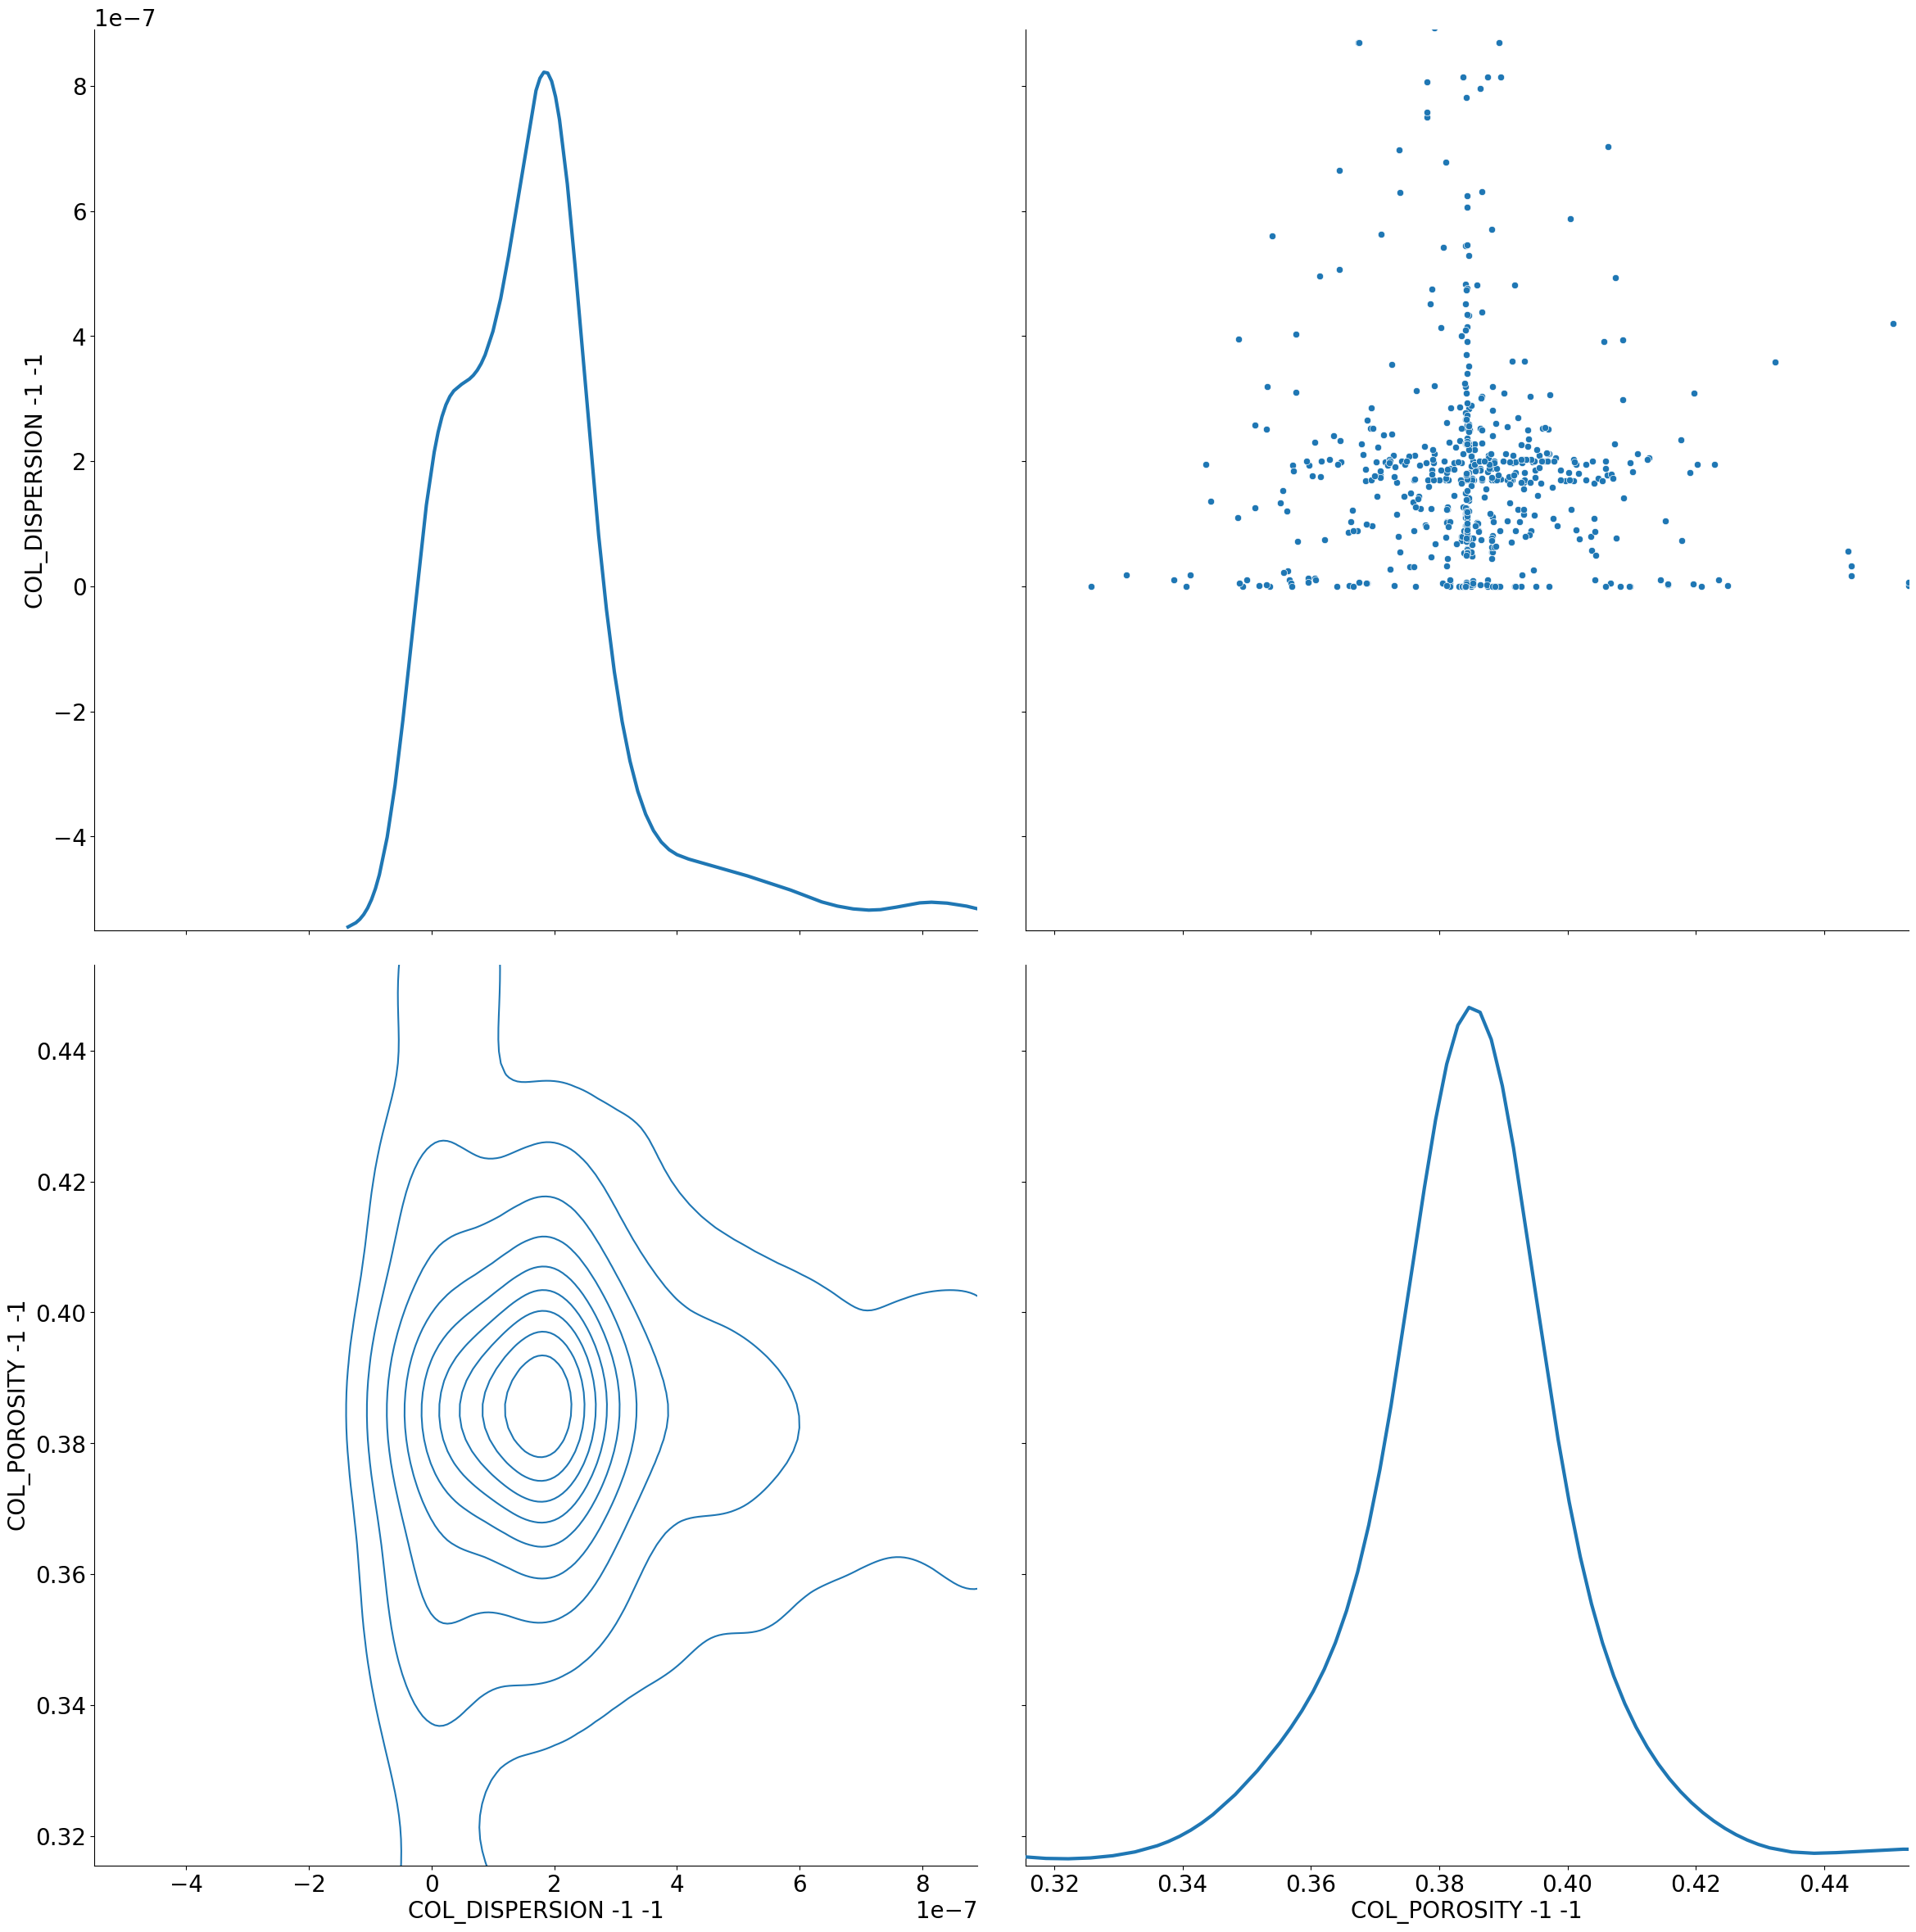

In [14]:
match.plot_corner()

Best item fcc41980512a84fea76638d5b86efbc7 for meta score(s) Product Root Score , Min Score , Mean Score , SSE


,Time,Name,Method,Condition Number,COL_DISPERSION Comp:-1 Bound:-1,COL_POROSITY Comp:-1 Bound:-1,dextran_Pulse_SSE,Product Root Score,Min Score,Mean Score,SSE,RMSE
0,Tue Oct 26 11:57:40 2021,fcc41980512a84fea76638d5b86efbc7,GRAD,4.671524,2.000000e-07,0.384315,1.521612e-25,1.521612e-25,1.521612e-25,1.521612e-25,1.521612e-25,1.825117e-14


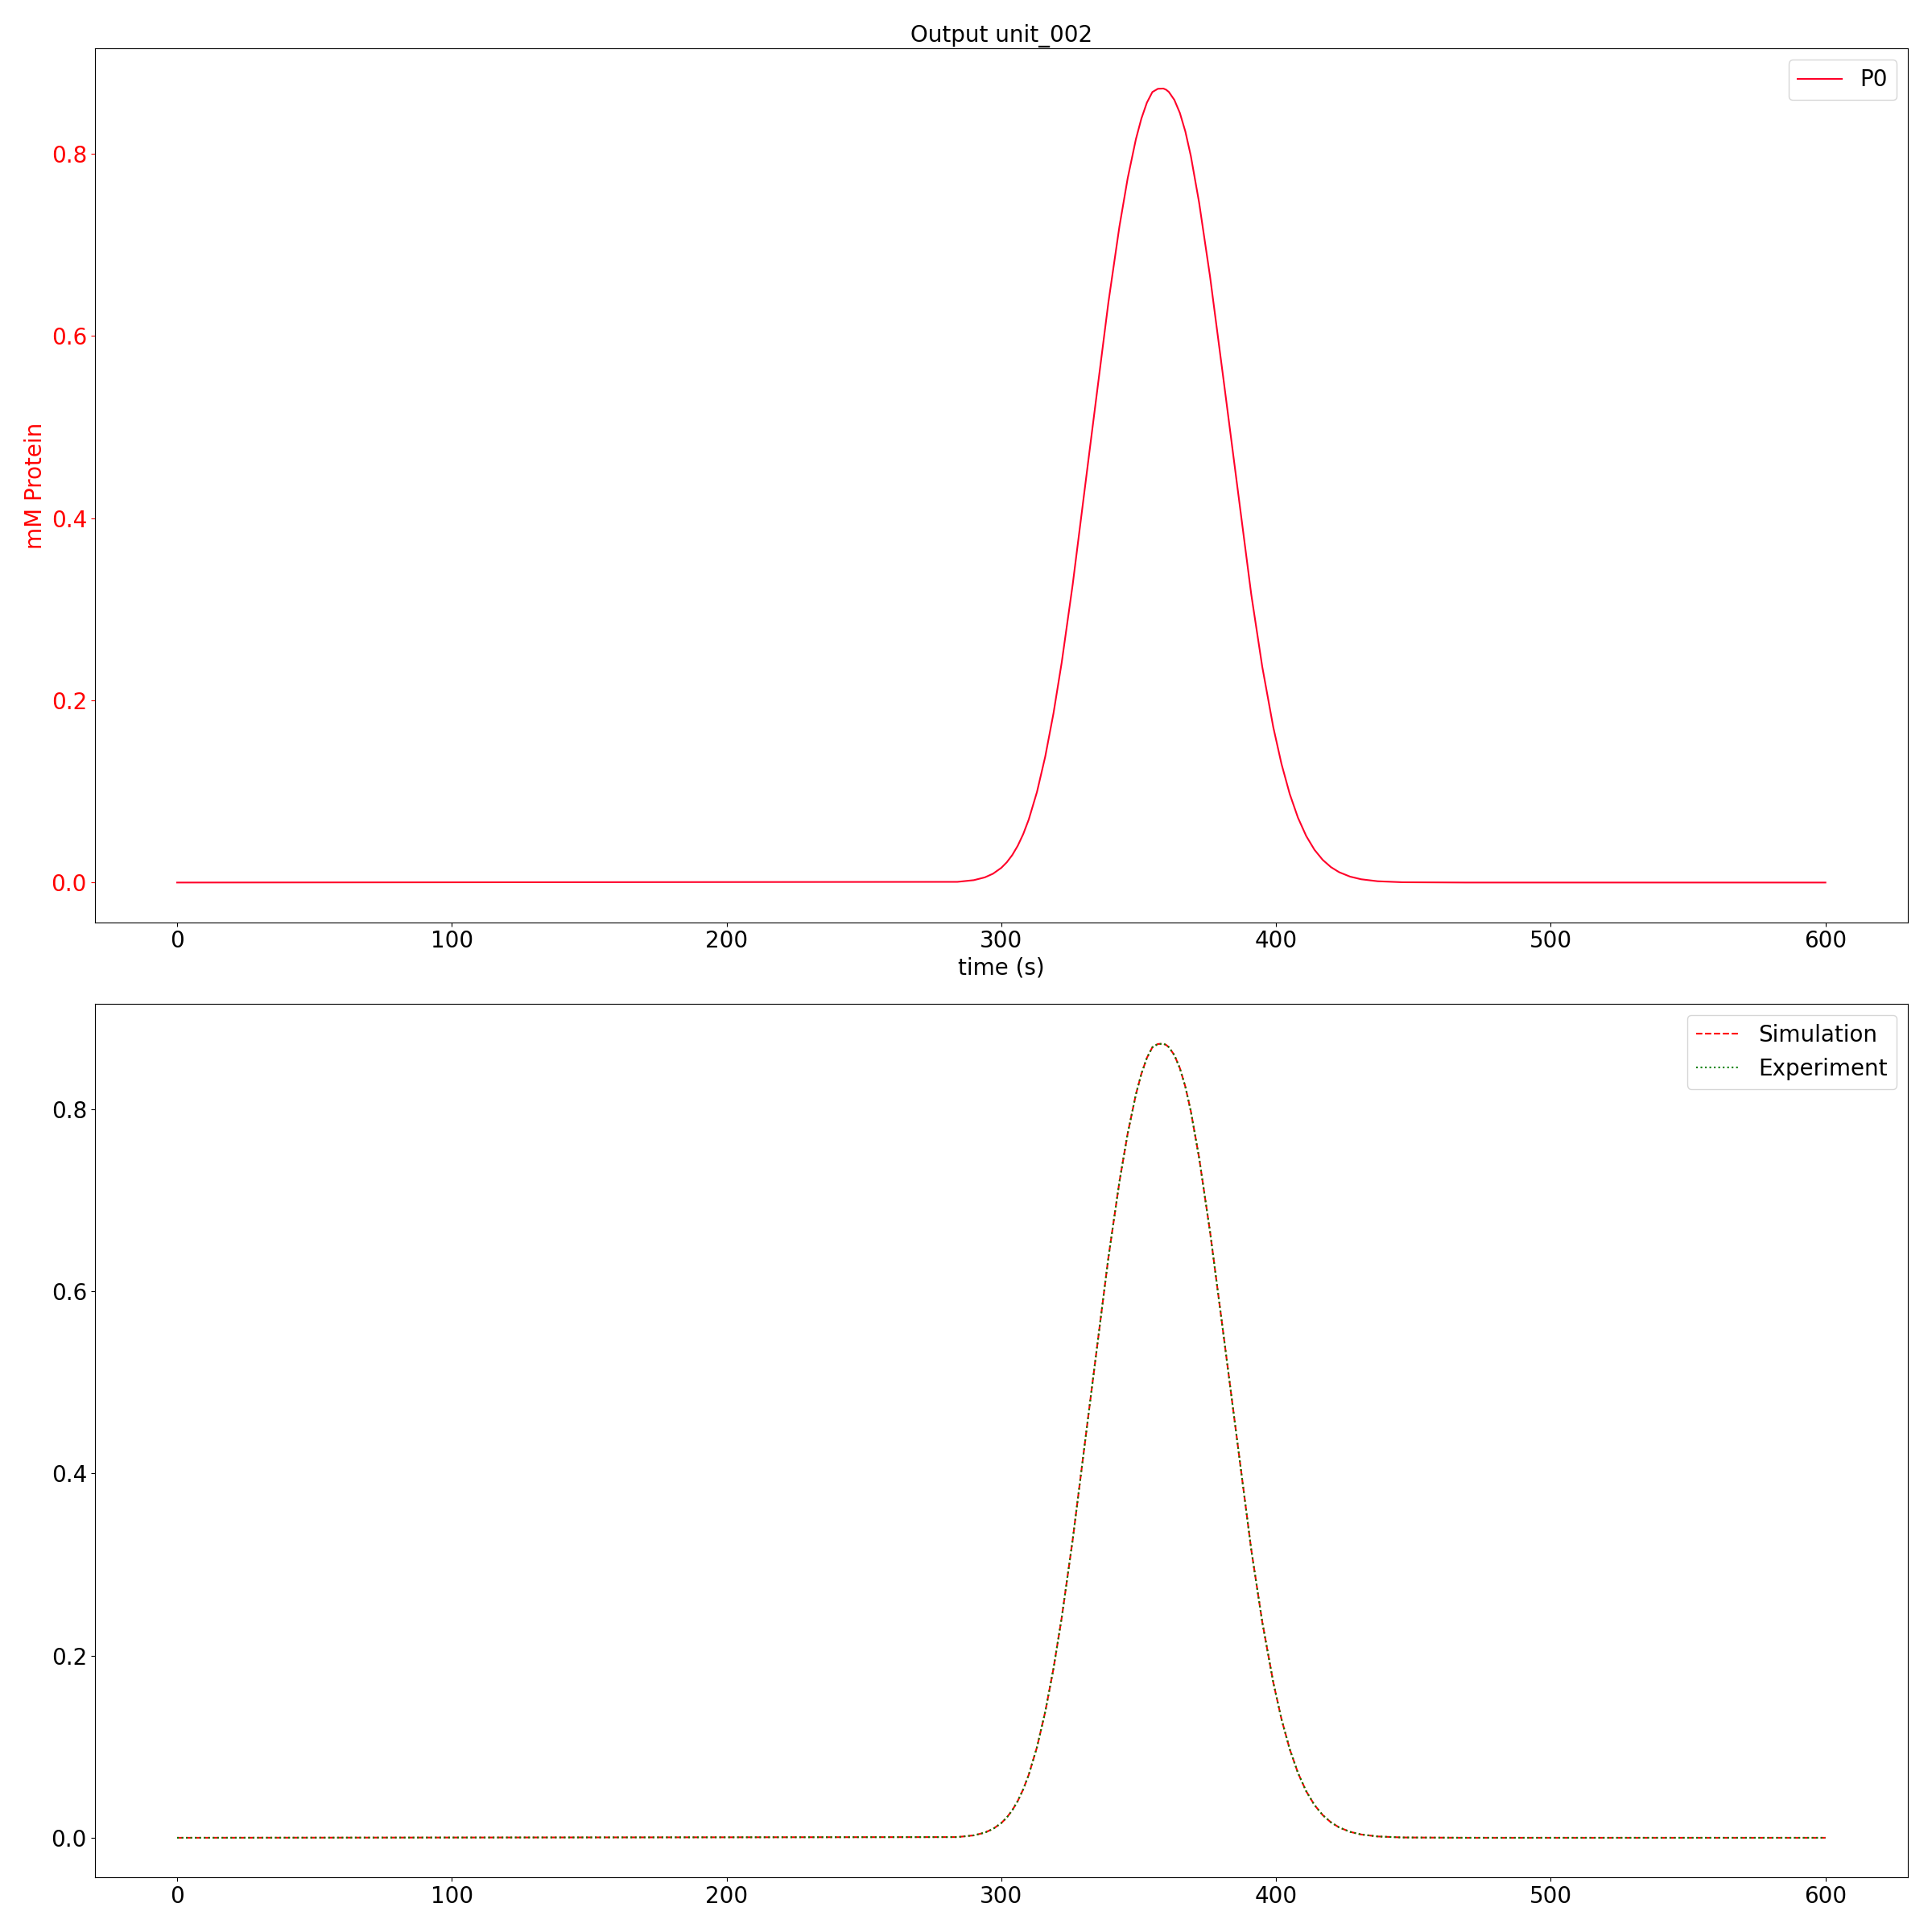

In [15]:
match.plot_best()